# Preparación

In [ ]:
import numpy as np
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn import svm, preprocessing
from sklearn.ensemble import AdaBoostClassifier
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install ipywidgets
# To enable `ipywidgets`
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from ipywidgets import widgets
from IPython.display import display

In [ ]:
!pip install -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 45.3 MB/s eta 0:00:00


In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 545 µs (started: 2023-06-30 15:40:35 +00:00)


In [ ]:
%%capture
!pip install dwave-ocean-sdk

time: 34.5 s (started: 2023-06-30 15:40:35 +00:00)


In [ ]:
%%capture
!git clone https://github.com/dwavesystems/dwave-ocean-sdk.git
!cd dwave-ocean-sdk
!python setup.py install

time: 1.73 s (started: 2023-06-30 15:41:10 +00:00)


In [ ]:
import numpy.lib.recfunctions as rfn
import dimod
from dwave.system import LeapHybridSampler, EmbeddingComposite
from dwave.system.samplers import DWaveSampler

time: 824 ms (started: 2023-06-30 15:41:11 +00:00)


In [1]:
def get_token(path):
  with open("token.txt", "r") as file:
    token = file.read()

  return token

In [2]:
endpoint = 'https://cloud.dwavesys.com/sapi'
token = get_token('token.txt')

# Recolección de datos

Todos los conjuntos de datos están disponibles en Google Drive

In [ ]:
dropdown = widgets.Dropdown(options =["DoS", "Fuzzy", "Gear", "RPM"])
output = widgets.Output()
path = '/content/drive/MyDrive/tfg/datasets/DoS_stratified.csv'

def select(change):
  global path
  output.clear_output()
  if(change.new == 'DoS'):
    with output:
      path = '/content/drive/MyDrive/tfg/datasets/DoS_stratified.csv'
  elif(change.new == 'Fuzzy'):
    with output:
      path = '/content/drive/MyDrive/tfg/datasets/Fuzzy_stratified.csv'
  elif(change.new == 'Gear'):
    with output:
      path = '/content/drive/MyDrive/tfg/datasets/gear_stratified.csv'
  elif(change.new == 'RPM'):
    with output:
      path = '/content/drive/MyDrive/tfg/datasets/RPM_stratified.csv'
  else:
    with output:
      display("Error: option not found")

dropdown.observe(select, names="value")
display(dropdown)
display(output)

Dropdown(options=('DoS', 'Fuzzy', 'Gear', 'RPM'), value='DoS')

Output()

time: 18.4 ms (started: 2023-06-30 15:41:12 +00:00)


In [ ]:
columns = ['Tiempo', 'ID', 'DLC', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'Etiqueta', 'Delta']
df = pd.read_csv(path, delimiter=',', header=0, names=columns)

time_column = ['Tiempo']
# x_columns = ['ID', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'Delta']
x_columns = ['ID', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']
y_columns = ['Etiqueta']

time: 5.67 s (started: 2023-06-30 15:53:01 +00:00)


# Data Understanding

## Transformación de tipos

Vamos a cambiar los tipos de datos de las columnas para que el conjunto de datos ocupe menos.

In [ ]:
%%capture
def transformData(df):
  df = df.drop(['Tiempo', 'DLC'], axis=1)
  df['ID'] = df['ID'].astype('int16')
  df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']] = df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']].astype('int8')
  df['Etiqueta'] = df['Etiqueta'].astype('bool')

  return df

time: 805 µs (started: 2023-06-30 15:47:07 +00:00)


In [ ]:
%%capture
def transformData(df):
  df = df.drop(['Tiempo', 'DLC', 'Delta'], axis=1)
  df['ID'] = df['ID'].astype('int16')
  df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']] = df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']].astype('int8')
  df['Etiqueta'] = df['Etiqueta'].astype('bool')

  return df

time: 820 µs (started: 2023-06-30 15:53:09 +00:00)


In [ ]:
df = transformData(df)
print(df.dtypes)

ID          int16
M1           int8
M2           int8
M3           int8
M4           int8
M5           int8
M6           int8
M7           int8
M8           int8
Etiqueta     bool
dtype: object
time: 363 ms (started: 2023-06-30 15:53:15 +00:00)


## Exportación de muestras

In [ ]:
def writeDataset(df, original_path, sample_type=None):
  path = original_path.split('/')[-1].split('_')[0] + '_' + str(sample_type) + '.csv'
  df.to_csv(path, index=False)

time: 1.03 ms (started: 2023-06-29 08:43:40 +00:00)


In [ ]:
writeDataset(df, path, 'optimized')

NameError: ignored

time: 16.4 ms (started: 2023-06-29 16:51:25 +00:00)


# Modeling

## Computación clásica

Por motivos de completitud, vamos a utilizar la técnica de hiperparametrización para los algoritmos clásicos. Esto nos va a permitir encontrar los mejores valores que podemos asignar a los parámetros para obtener los mejores resultados.

In [ ]:
ds = df

train, test = train_test_split(ds, test_size=0.2, random_state=42)

x_train = train[x_columns]
y_train = train[y_columns]

x_test = test[x_columns]
y_test = test[y_columns]

time: 1.6 s (started: 2023-06-30 15:47:08 +00:00)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
f1_sc = f1_score(y_test, y_pred, average='micro')
print(f1_sc)
df_relevancia = pd.DataFrame({'Variable': clf.feature_names_in_, 'Relevancia': clf.feature_importances_})
df_relevancia = df_relevancia.sort_values('Relevancia', ascending=False)
print(df_relevancia)


1.0
  Variable  Relevancia
0       ID         1.0
1       M1         0.0
2       M2         0.0
3       M3         0.0
4       M4         0.0
5       M5         0.0
6       M6         0.0
7       M7         0.0
8       M8         0.0
9    Delta         0.0
time: 1.36 s (started: 2023-06-29 09:06:16 +00:00)


### SVM

Para utilizar la hiperparametrización, vamos a definir la siguiente matriz de parámetros.

In [ ]:
%%capture
param_grid = [{'C': [1, 2, 5], 'max_iter': [50, 100, 200, 500], 'kernel': ['linear', 'rbf', 'poly']}]

svmClf = svm.SVC()
clf = GridSearchCV(svmClf, param_grid)
clf.fit(x_train, y_train)

time: 1h 17min 34s (started: 2023-06-30 00:28:15 +00:00)


In [ ]:
y_pred = clf.predict(x_test)

time: 10.2 s (started: 2023-06-30 01:45:49 +00:00)


In [ ]:
f1_sc = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score Result: {f1_sc}')
print(f'Best parameters: {clf.best_params_}')

F1 Score Result: 0.7107149174438392
Best parameters: {'C': 1, 'kernel': 'poly', 'max_iter': 500}
time: 178 ms (started: 2023-06-30 01:45:59 +00:00)


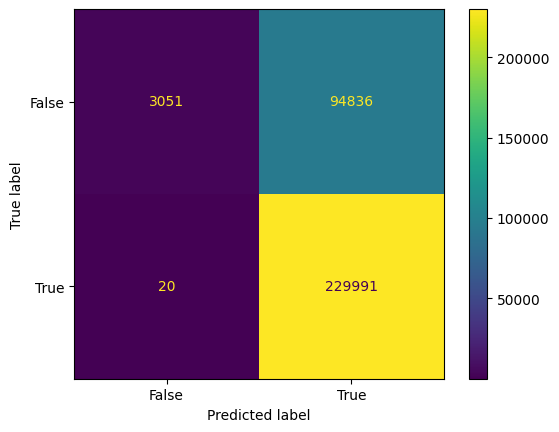

time: 469 ms (started: 2023-06-30 01:46:00 +00:00)


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

### AdaBoost

In [ ]:
%%capture
param_grid = [{'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.1, 0.25, 0.5, 1, 2], 'random_state': [42]}]

adaClf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf = GridSearchCV(adaClf, param_grid)
clf.fit(x_train, y_train)

time: 4h 31min 22s (started: 2023-06-30 07:52:51 +00:00)


In [ ]:
y_pred = clf.predict(x_test)

time: 7.82 s (started: 2023-06-30 12:24:13 +00:00)


In [ ]:
f1_sc = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score Result: {f1_sc}')
print(f'Best parameters: {clf.best_params_}')

F1 Score Result: 0.9999664529823299
Best parameters: {'learning_rate': 1, 'n_estimators': 200, 'random_state': 42}
time: 131 ms (started: 2023-06-30 12:24:21 +00:00)


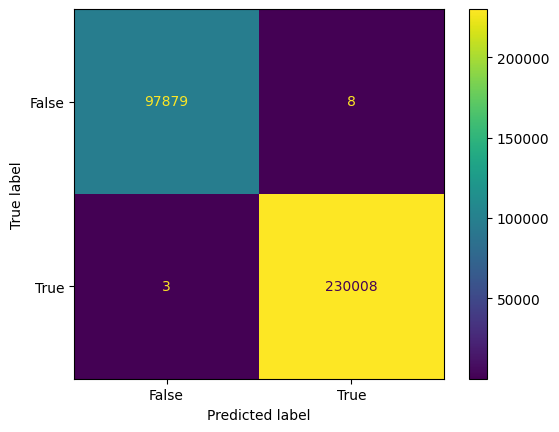

time: 344 ms (started: 2023-06-30 12:24:21 +00:00)


In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

## Comparación de algoritmos SVM

Gracias al preprocesamiento realizado en esta iteración, hemos podido aumentar el tamaño de los conjuntos que pueden tomar como entrada cada modelo.

El objetivo de esta iteración es comprobar si normalizando los conjuntos de datos y utilizando la técnica de hiperparametrización podemos conseguir mejores resultados en los modelos cuánticos.

In [ ]:
d = preprocessing.normalize(df[x_columns])
df_normalized = pd.DataFrame(d, columns=df.columns)
df_normalized[y_columns] = df[y_columns]

time: 1.8 s (started: 2023-06-30 15:53:36 +00:00)


In [ ]:
ds = df_normalized.sample(n=80, replace=False, random_state=42)

time: 485 ms (started: 2023-06-30 15:53:38 +00:00)


In [ ]:
train, test = train_test_split(ds, test_size=0.2, random_state=42)

x_train = train[x_columns]
y_train = train[y_columns]

x_test = test[x_columns]
y_test = test[y_columns]

time: 22.5 ms (started: 2023-06-30 15:53:39 +00:00)


### SVM

Para utilizar la hiperparametrización, vamos a definir la siguiente matriz de parámetros.

In [ ]:
%%capture
# param_grid = [{'C': [1, 2, 5], 'max_iter': [10000], 'kernel': ['linear']},
#               {'C': [1, 2, 5], 'max_iter': [10000], 'kernel': ['rbf', 'poly']}]

param_grid = [{'C': [1, 2, 5], 'max_iter': [50, 100, 200, 500], 'kernel': ['linear', 'rbf', 'poly']}]

svmClf = svm.SVC()
clf = GridSearchCV(svmClf, param_grid)
clf.fit(x_train, y_train)

ValueError: ignored

time: 1.62 s (started: 2023-06-29 09:03:48 +00:00)


In [ ]:
y_pred = clf.predict(x_test)

NotFittedError: ignored

time: 14.5 ms (started: 2023-06-29 08:43:58 +00:00)


In [ ]:
f1_sc = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score Result: {f1_sc}')

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=svmClf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svmClf.classes_)
disp.plot()
plt.show()

### Adiabatic (QSVM)

In [ ]:
def kernel(xn, xm, gamma=-1):
    if gamma == -1:
        return xn @ xm.T
    xn = np.atleast_2d(xn)
    xm = np.atleast_2d(xm)
    return np.exp(-gamma * np.sum((xn[:,None] - xm[None,:])**2, axis=-1))

def gen_svm_qubos(B,K,xi,gamma, train, labels):
    N = len(train)

    Q = np.zeros((K*N,K*N))
    print(f'Creating the QUBO of size {Q.shape}')
    for n in range(N):
        for m in range(N):
            for k in range(K):
                for j in range(K):
                    Q[K*n+k,K*m+j] = 0.5 * B**(k+j) * labels[n] * labels[m] * (kernel(train[n], train[m], gamma) + xi)
                    if n == m and k == j:
                        Q[K*n+k,K*m+j] += - B**k

    Q = np.triu(Q) + np.tril(Q,-1).T # turn the symmetric matrix into upper triangular

    return Q

def train_qsvm(B, K, xi, gamma, x_train, y_train):
  Q = gen_svm_qubos(B, K, xi, gamma, x_train, y_train)

  sampler = EmbeddingComposite(DWaveSampler(token=token, endpoint=endpoint))
  response = sampler.sample_qubo(Q, label='QBoost')

  return response

def predict(B, K, xi, gamma, alphas, data, label, datatest):

    C=(B**np.arange(K)).sum()

    b = calculate_bias(alphas, data, label, gamma, C)

    scoretest = distance_to_hyperplane(datatest, alphas, data, label, gamma, b)

    return scoretest

def distance_to_hyperplane(x, alphas, data, label, gamma, b=0): # evaluates the distance to the hyper plane according to 16.5.32 on p. 891 (Numerical Recipes); sign is the assigned class; x.shape = ...xD
    return np.sum((alphas * label)[:,None] * kernel(data, x, gamma), axis=0) + b

def calculate_bias(alphas, data, label, gamma, C): # evaluates offset b according to 16.5.33
    cross = distance_to_hyperplane(data, alphas, data, label, gamma)
    return np.sum(alphas * (C-alphas) * (label - cross)) / np.sum(alphas * (C-alphas))

def decode(binary, B=10, K=3):
    N = len(binary) // K
    Bvec = B ** np.arange(K)
    return np.fromiter(binary,float).reshape(N,K) @ Bvec

def predict_score_qsvm(B, K, xi, gamma, data, label, x_test, response):
  samples = np.array([''.join(map(str,sample)) for sample in response.record['sample']])
  unique_samples, unique_idx, unique_counts = np.unique(samples, return_index=True, return_counts=True)
  unique_records = response.record[unique_idx]
  result = rfn.merge_arrays((unique_samples, unique_records['energy'], unique_counts, unique_records['chain_break_fraction']))
  result = result[np.argsort(result['f1'])]
  MAXRESULTS = 20

  alphas = np.array([decode(sample,B,K) for sample in result['f0'][:MAXRESULTS]])
  alphas = alphas.reshape(len(alphas[0]), 1)
  scores = predict(B, K, xi, gamma, alphas, data, label, x_test)

  return scores

def predict_labels_qsvm(scores):
  avg_scores=np.zeros((scores[0].shape[0]))
  Y_predicted=np.zeros((scores[0].shape[0]),int)
  average = np.average(scores)

  for i in range(0,scores[0].shape[0]):
      tmp=0
      for y in range(0,1):
          tmp=tmp+scores[y][i]
      avg_scores[i]=tmp/1

  for i in range(0,scores[0].shape[0]):
      if(avg_scores[i]<0):
          Y_predicted[i]=-1
      else:
          Y_predicted[i]=1


  return Y_predicted

def f1_score_qsvm(y_pred, y_test):
  tp = 0
  fn = 0
  fp = 0

  for i in range(len(y_pred)):
    if(y_pred[i] == y_test[i] and y_pred[i] == 1):
      tp += 1
    elif(y_pred[i] == 1 and y_test[i] == -1):
      fp += 1
    elif(y_pred[i] == -1 and y_test[i] == 1):
      fn += 1

  if tp + fn == 0 or tp + fp == 0:
    return 0

  recall = tp / (tp + fn)
  precision = tp / (tp + fp)
  f1_score = 2 * precision * recall / (precision + recall)

  return f1_score

time: 5.14 ms (started: 2023-06-30 15:48:25 +00:00)


In [ ]:
train, test = train_test_split(ds, test_size=0.2, random_state=42)

x_train = preprocessing.scale(train[x_columns].to_numpy())
y_train = train[y_columns]
y_train['Etiqueta'] = y_train['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)
y_train = y_train.to_numpy()

x_test = preprocessing.scale(test[x_columns].to_numpy())
y_test = test[y_columns]
y_test['Etiqueta'] = y_test['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)
y_test = y_test.to_numpy()

time: 25.3 ms (started: 2023-06-30 15:54:15 +00:00)


<ipython-input-35-3e0a7d7ff7f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Etiqueta'] = y_train['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)
<ipython-input-35-3e0a7d7ff7f9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Etiqueta'] = y_test['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)


Las matrices de los elementos que utilizan en el repositorio original eran más amplias. Sin embargo, los mejores resultados se encontraban alrededor de

In [ ]:
# B=[2,3,5,10]
B=[2,10]
K=[2]
xi=[0,3,5]
gamma=[-1,0.125,0.25,0.5,1,2]
# gamma=[-1,0.5,1,2,8]

best_acc = 0
best_B = 0
best_K = 0
best_xi = 0
best_gamma = 0
for i in B:
  for j in K:
    for k in xi:
      for l in gamma:
        response = train_qsvm(i, j, k, l, x_train, y_train)
        scores = predict_score_qsvm(i, j, k, l, x_train, y_train, x_test, response)
        y_pred = predict_labels_qsvm(scores)
        accuracy = f1_score_qsvm(y_pred, y_test)
        print(accuracy)

        if (accuracy > best_acc):
          best_acc = accuracy
          best_B = i
          best_K = j
          best_xi = k
          best_gamma = l

print(best_acc)
print('B: ' + str(best_B))
print('K: ' + str(best_K))
print('xi: ' + str(best_xi))
print('gamma: ' + str(best_gamma))

Creating the QUBO of size (128, 128)
0.7692307692307692
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0.7692307692307692
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating the QUBO of size (128, 128)
0
Creating the QUBO of size (128, 128)
0.7272727272727272
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating the QUBO of size (128, 128)
0.8571428571428571
Creating th

In [ ]:
best_B = 10
best_K = 3
best_xi = 5
best_gamma = -1

time: 9.55 ms (started: 2023-06-30 15:48:56 +00:00)


In [ ]:
response = train_qsvm(best_B, best_K, best_xi, best_gamma, x_train, y_train)

Creating the QUBO of size (192, 192)


ValueError: ignored

time: 17min 5s (started: 2023-06-30 15:54:19 +00:00)


In [ ]:
scores = predict_score_qsvm(best_B, best_K, best_xi, best_gamma, x_train, y_train, x_test, response)
y_pred = predict_labels_qsvm(scores)

time: 796 ms (started: 2023-06-23 11:26:47 +00:00)


In [ ]:
print(scores)

[[-1.27221691 -1.25414121  0.43638359  0.31866942 -1.13616672 -1.27236162
  -1.23572173  0.34137302]
 [-1.27183905 -1.27010715 -0.71742098 -1.16309807 -1.26932505 -1.27233985
  -0.70041812 -1.16039418]
 [-1.2722834  -1.2723626  -1.27193849 -1.27235474 -1.27235856 -1.27236265
  -1.27236238 -1.2723589 ]
 [-1.26975466 -1.25959573  0.26130013 -0.89318384 -1.24324491 -1.27235496
  -1.24452632  0.33273655]
 [-1.26975596 -1.2595684   0.26003848 -0.89268689 -1.24327003 -1.27235495
  -1.24446338  0.33069326]
 [-1.27236265 -1.27236264 -1.27235927 -1.27236265 -1.27236081 -1.27236263
  -1.27236204 -1.27236009]
 [-1.27236236 -1.2646277   0.91334877 -1.1144814  -0.63864439 -1.27235537
  -1.22487427 -1.04657424]
 [-1.2713334  -1.26137055  0.41443072 -1.04615403 -1.21684009 -1.2723611
  -1.2644286   1.0767356 ]
 [-1.27236265 -1.27236265 -1.27236265 -1.27236265 -1.27236265 -1.27236265
  -1.27236265 -1.27236265]
 [-1.27236208 -1.27178032 -1.18731416 -1.26698104  0.04734351 -1.27235028
  -1.26954089 -1.2

In [ ]:
print(y_pred)
test_labels = y_test.reshape(1, len(y_test))[0]
print(test_labels)
print(f1_score_qsvm(y_pred, test_labels))

[1 1 1 1 1 1 1 1]
[-1  1  1  1  1  1  1  1]
0.9333333333333333
time: 2.05 ms (started: 2023-06-23 11:28:41 +00:00)


## Comparación de algoritmos Gradient Boosting

In [ ]:
ds = df_normalized.sample(n=30000, replace=False, random_state=42)

In [ ]:
train, test = train_test_split(ds, test_size=0.2, random_state=42)

x_train = train[x_columns]
y_train = train[y_columns]

x_test = test[x_columns]
y_test = test[y_columns]

### AdaBoost

In [ ]:
%%capture
param_grid = [{'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.1, 0.25, 0.5, 1, 2], 'random_state': [42]}]

adaClf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf = GridSearchCV(adaClf, param_grid)
clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
f1_sc = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score Result: {f1_sc}')

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=adaClf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=adaClf.classes_)
disp.plot()
plt.show()

### Adiabatic (QBoost)

In [ ]:
y_train['Etiqueta'] = y_train['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)
y_train = y_train.to_numpy()
x_train = x_train.to_numpy()

y_test['Etiqueta'] = y_test['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)
y_test = y_test.to_numpy()
x_test = x_test.to_numpy()

time: 1.26 s (started: 2023-06-30 15:47:14 +00:00)


<ipython-input-17-372b33ff9e50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['Etiqueta'] = y_train['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)
<ipython-input-17-372b33ff9e50>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Etiqueta'] = y_test['Etiqueta'].apply(lambda cell : -1 if cell == 0 else 1)


In [ ]:
class DecisionStumpClassifier:
    """Decision tree classifier that operates on a single feature with a single splitting rule.

    The index of the feature used in the decision rule is stored
    relative to the original data frame.
    """

    def __init__(self, X, y, feature_index):
        """Initialize and fit the classifier.

        Args:
            X (array):
                2D array of feature vectors.  Note that the array
                contains all features, while the weak classifier
                itself uses only a single feature.
            y (array):
                1D array of class labels, as ints.  Labels should be
                +/- 1.
            feature_index (int):
                Index for the feature used by the weak classifier,
                relative to the overall data frame.
        """
        self.i = feature_index

        self.clf = DecisionTreeClassifier(max_depth=1)
        self.clf.fit(X[:, [feature_index]], y)

    def predict(self, X):
        """Predict class.

        Args:
            X (array):
                2D array of feature vectors.  Note that the array
                contains all features, while the weak classifier
                itself will make a prediction based only a single
                feature.

        Returns:
            Array of class labels.
        """
        return self.clf.predict(X[:, [self.i]])

class EnsembleClassifier:
    """Ensemble of weak classifiers."""

    def __init__(self, weak_classifiers, weights, weak_classifier_scaling, offset=1e-9):
        """Initialize ensemble from list of weak classifiers and weights.

        Args:
            weak_classifiers (list):
                List of classifier instances.
            weights (array):
                Weights associated with the weak classifiers.
            weak_classifier_scaling (float):
                Scaling for weak classifier outputs.
            offset (float):
                Offset value for ensemble classifier.  The default
                value is a small positive number used to prevent
                ambiguous 0 predictions when weak classifiers exactly
                balance each other out.
        """
        self.classifiers = weak_classifiers
        self.w = weights
        self.weak_clf_scale = weak_classifier_scaling
        self.offset = offset

    def predict(self, X):
        """Compute ensemble prediction.

        Note that this function returns the numerical value of the
        ensemble predictor, not the class label.  The predicted class
        is sign(predict()).
        """
        H = _build_H(self.classifiers, X, self.weak_clf_scale)

        # If we've already filtered out those with w=0 and we are only
        # using binary weights, this is just a sum
        preds = np.dot(H, self.w)
        return preds - self.offset

    def predict_class(self, X):
        """Compute ensemble prediction of class label."""
        preds = self.predict(X)

        # Add a small perturbation to any predictions that are exactly
        # 0, because these will not count towards either class when
        # passed through the sign function.  Such zero predictions can
        # happen when the weak classifiers exactly balance each other
        # out.
        preds[preds == 0] = 1e-9

        return np.sign(preds)

    def score(self, X, y):
        """Compute accuracy score on given data."""
        if sum(self.w) == 0:
            # Avoid difficulties that occur with handling this below
            return 0.0
        return f1_score(y, self.predict_class(X))

    def squared_error(self, X, y):
        """Compute squared error between predicted and true labels.

        Provided for testing purposes.
        """
        p = self.predict(X)
        return sum((p - y)**2)

    def fit_offset(self, X):
        """Fit offset value based on class-balanced feature vectors.

        Currently, this assumes that the feature vectors in X
        correspond to an even split between both classes.
        """
        self.offset = 0.0
        # Todo: review whether it would be appropriate to subtract
        # mean(y) here to account for unbalanced classes.
        self.offset = np.mean(self.predict(X))

    def get_selected_features(self):
        """Return list of features corresponding to the selected weak classifiers."""
        return [clf.i for clf, w in zip(self.classifiers, self.w) if w > 0]

    def get_confusion_matrix(self, X, y):
        return confusion_matrix(y, self.predict_class(X), labels=[-1, 1])

class QBoostClassifier(EnsembleClassifier):
    """Construct an ensemble classifier using quadratic loss minimization.

    """

    def __init__(self, X, y, lam, weak_clf_scale=None, drop_unused=True):
        """Initialize and fit QBoost classifier.

        X should already include all candidate features (e.g., interactions).

        Args:
            X (array):
                2D array of feature vectors.
            y (array):
                1D array of class labels (+/- 1).
            lam (float):
                regularization parameter.
            weak_clf_scale (float or None):
                scale factor to apply to weak classifier outputs.  If
                None, scale by 1/num_classifiers.
            drop_unused (bool):
                if True, only retain the nonzero weighted classifiers.
        """
        if not all(np.isin(y, [-1, 1])):
            raise ValueError("Class labels should be +/- 1")

        num_features = np.size(X, 1)

        if weak_clf_scale is None:
            weak_clf_scale = 1 / num_features

        wclf_candidates = [DecisionStumpClassifier(
            X, y, i) for i in range(num_features)]

        H = _build_H(wclf_candidates, X, weak_clf_scale)

        # For reference, store individual weak classifier scores.
        # Note: we don't check equality h==y here because H might be rescaled.
        self.weak_scores = np.array([np.mean(np.sign(h) * y > 0) for h in H.T])

        weights, self.energy = _minimize_squared_loss_binary(H, y, lam)

        # Store only the selected classifiers
        if drop_unused:
            weak_classifiers = [wclf for wclf, w in zip(
                wclf_candidates, weights) if w > 0]
            weights = weights[weights > 0]
        else:
            weak_classifiers = wclf_candidates

        super().__init__(weak_classifiers, weights, weak_clf_scale)
        self.fit_offset(X)

        # Save candidates so we can provide a baseline accuracy report.
        self._wclf_candidates = wclf_candidates

    def report_baseline(self, X, y):
        """Report accuracy of weak classifiers.

        This provides context for interpreting the performance of the boosted
        classifier.
        """
        scores = np.array([accuracy_score(y, clf.predict(X))
                           for clf in self._wclf_candidates])
        data = [[len(scores), scores.min(), scores.mean(), scores.max(), scores.std()]]
        headers = ['count', 'min', 'mean', 'max', 'std']

        print('Accuracy of weak classifiers (score on test set):')
        print(tabulate(data, headers=headers, floatfmt='.3f'))

def _build_H(classifiers, X, output_scale):
    """Construct matrix of weak classifier predictions on given set of input vectors."""
    H = np.array([clf.predict(X) for clf in classifiers], dtype=float).T

    # Rescale H
    H *= output_scale

    return H

def qboost_lambda_sweep(X, y, lambda_vals, val_fraction=0.4, verbose=False, **kwargs):
    """Run QBoost using a series of lambda values and check accuracy against a validation set.

    Args:
        X (array):
            2D array of feature vectors.
        y (array):
            1D array of class labels (+/- 1).
        lambda_vals (array):
            Array of values for regularization parameter, lambda.
        val_fraction (float):
            Fraction of given data to set aside for validation.
        verbose (bool):
            Print out diagnostic information to screen.
        kwargs:
            Passed to QBoost.__init__.

    Returns:
        QBoostClassifier:
            QBoost instance with best validation score.
        lambda:
            Lambda value corresponding to the best validation score.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_fraction)

    best_score = -1
    best_lambda = None
    best_clf = None

    if verbose:
        print('{:7} {} {}:'.format('lambda', 'n_features', 'score'))

    for lam in lambda_vals:
        qb = QBoostClassifier(X_train, y_train, lam, **kwargs)
        score = qb.score(X_val, y_val)
        if verbose:
            print('{:<7.4f} {:<10} {:<6.3f}'.format(
                lam, len(qb.get_selected_features()), score))
        if score > best_score:
            best_score = score
            best_clf = qb
            best_lambda = lam

    return best_clf, lam

def _build_bqm(H, y, lam):
    """Build BQM.

    Args:
        H (array):
            2D array of weak classifier predictions.  Each row is a
            sample point, each column is a classifier.
        y (array):
            Outputs
        lam (float):
            Coefficient that controls strength of regularization term
            (larger values encourage decreased model complexity).
    """
    n_samples = np.size(H, 0)
    n_classifiers = np.size(H, 1)

    # samples_factor is a factor that appears in front of the squared
    # loss term in the objective.  In theory, it does not affect the
    # problem solution, but it does affect the relative weighting of
    # the loss and regularization terms, which is otherwise absorbed
    # into the lambda parameter.

    # Using an average seems to be more intuitive, otherwise, lambda
    # is sample-size dependent.
    samples_factor = 1.0 / n_samples

    bqm = dimod.BQM('BINARY')
    bqm.offset = samples_factor * n_samples

    for i in range(n_classifiers):
        # Note: the last term with h_i^2 is part of the first term in
        # Eq. (12) of Neven et al. (2008), where i=j.
        bqm.add_variable(i, lam - 2.0 * samples_factor *
                         np.dot(H[:, i], y) + samples_factor * np.dot(H[:, i], H[:, i]))

    for i in range(n_classifiers):
        for j in range(i+1, n_classifiers):
            # Relative to Eq. (12) from Neven et al. (2008), the
            # factor of 2 appears here because each term appears twice
            # in a sum over all i,j.
            bqm.add_interaction(
                i, j, 2.0 * samples_factor * np.dot(H[:, i], H[:, j]))

    return bqm


def _minimize_squared_loss_binary(H, y, lam):
    """Minimize squared loss using binary weight variables."""
    bqm = _build_bqm(H, y, lam)

    sampler = EmbeddingComposite(DWaveSampler(token=token, endpoint=endpoint))
    results = sampler.sample(bqm, label='QBoost')
    weights = np.array(list(results.first.sample.values()))
    energy = results.first.energy

    return weights, energy

time: 3.66 ms (started: 2023-06-30 15:47:15 +00:00)


In [ ]:
normalized_lambdas = np.linspace(0.0, 0.5, 50)
lambdas = normalized_lambdas / len(ds)
print('Performing cross-validation using {} values of lambda, this may take several minutes...'.format(len(lambdas)))
qboost, lam = qboost_lambda_sweep(
    x_train, y_train, lambdas, verbose=False)

In [ ]:
lam = 0.0006944444444444445
qboost = QBoostClassifier(x_train, y_train, lam)

In [ ]:
print(lam)

In [ ]:
print('Score on test set: {:.3f}'.format(qboost.score(x_test, y_test)))

In [ ]:
cm = qboost.get_confusion_matrix(x_test, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()